# Part 4

## Google Collab mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
%cd drive/"My Drive"/ECSE-415-Project/Submission

/content/drive/My Drive/ECSE-415-Project/Submission


## Library imports

In [3]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
import cv2
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from skimage.feature import local_binary_pattern
from sklearn.metrics import confusion_matrix as conf_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import itertools
import warnings
import pickle

     |████████████████████████████████| 25.0MB 88kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28
     |████████████████████████████████| 30.6MB 76kB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [0]:
random.seed(13)

## Extraction of patches

In [0]:
def extract_patch(img, keypoint, 
                  patch_size=15):
  
  if type(keypoint) is np.ndarray:
    x= int(keypoint[0])
    y= int(keypoint[1])
  
  else:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1])
  shape = img.shape

  left = x-patch_size//2
  right = left+patch_size
  top = y-patch_size//2
  bot = top+patch_size 

# if its out of bounds, reject it
  if(left<0 or top<0 or right>shape[0] or bot > shape[1]):
    return None
  patch = img[left:right, top:bot,:]
  return patch

def get_patches(imgs, all_keypoints, 
                patch_size=15):
  all_patches = []
  for img,keypoints in zip(imgs,all_keypoints):
    img_patches = []
    for keypoint in keypoints:
      patch = extract_patch(img,keypoint, patch_size)
      if patch is not None:
        img_patches.append(patch)
    all_patches.append(img_patches)
  return all_patches

## SIFT features extraction

In [0]:
def all_sift(array_all_img):
  all_img_descriptors = []
  all_img_keypoints = []
  for img in array_all_img:
    img = img.astype('uint8')
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    all_img_descriptors.append(descriptors)
    all_img_keypoints.append(keypoints)
  
  return all_img_keypoints, all_img_descriptors

In [0]:
def crop_sift(array_all_keypoints, array_all_bb):
  all_img_cropped_keypoints = []
  for list_keypoints, coord in zip(array_all_keypoints,array_all_bb):
    x1,y1,w,h = coord
    x2 = x1 + w
    y2 = y1 + h

    img_keypoints = []
    for k in list_keypoints:
      x,y = k.pt
      if x > x1 and x < x2 and y > y1 and y < y2:
        img_keypoints.append(k)
    
    all_img_cropped_keypoints.append(img_keypoints)

  return all_img_cropped_keypoints

    

## HoG

In [0]:
def extract_hog(patches, 
                cell_size = (3,3), block_size = (2,2), nbins = 9):
    img_shape = patches[0].shape

    hog = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                      img_shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)
    
    n_cells = (img_shape[0] // cell_size[0], img_shape[1] // cell_size[1])
    
    features = []
    for img in patches:
    # Compute HoG features
        feats = hog.compute(img)
        hog_feats = feats.flatten()
        features.append(hog_feats)
    return np.asarray(features)


def extract_hog_features(all_patches, 
                         cell_size= (3,3)):
  all_hog_feats = []  
  for img_patches in all_patches:
    hog_feats = extract_hog(img_patches,cell_size)
    all_hog_feats.append(hog_feats)
  return all_hog_feats


## LBP

In [0]:
def extract_lbp(patches, 
                radius_circle = 1,n_neighbour_set_points=8 ):

    features = []
    for img in patches:
    # Compute LBP features
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      lbp = local_binary_pattern(img, n_neighbour_set_points,
                                           radius_circle, method='uniform').flatten()
      features.append(lbp)

    return np.asarray(features)


def extract_lbp_features(all_patches, 
                         radius_circle=1):
  all_lbp_feats = []
  for img_patches in all_patches:
    lbp_feats = extract_lbp(img_patches,radius_circle)
    all_lbp_feats.append(lbp_feats)
  
  return all_lbp_feats


  

## Harris Corner Detection

In [0]:
def extract_harris(imgs, 
                   max_n_corners = 1000, quality = 0.01, 
                   min_distance = 5, block_size = 5  ):
  # Parameters for Harris corner detection
  dict_harris_params = dict( maxCorners = max_n_corners,
                              useHarrisDetector=True,
                          qualityLevel = quality,
                          minDistance = min_distance,
                          blockSize = block_size)

  all_img_keypoints = []
  for img in imgs:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    p= cv2.goodFeaturesToTrack(img, **dict_harris_params)
    if p is not None:
      all_img_keypoints.append(p.squeeze())
  
  return all_img_keypoints



In [0]:
def crop_harris(array_all_keypoints, array_all_bb):
  all_img_cropped_keypoints = []
  for list_keypoints, coord in zip(array_all_keypoints,array_all_bb):
    x1,y1,w,h = coord
    x2 = x1 + w
    y2 = y1 + h

    img_keypoints = []
    if list_keypoints.ndim == 1:
      list_keypoints = list_keypoints[np.newaxis]

    for p in list_keypoints:
      x,y = p
      if x > x1 and x < x2 and y > y1 and y < y2:
        img_keypoints.append(p)
    
    all_img_cropped_keypoints.append(img_keypoints)

  return all_img_cropped_keypoints

## BoW model

In [0]:
def bow_model(list_img_descs,n_clusters):
    # Flatten list of descriptors

    list_img_descs_flattened = list(itertools.chain.from_iterable(list_img_descs))

    # K means
    gmm_model= GMM(n_clusters)
    gmm_model.fit(list_img_descs_flattened )

    return gmm_model

def bow_vocab(gmm, img_descs, n_clusters):

    img_clustered_words = [gmm.predict(raw_words) for raw_words in img_descs]

    # Histogram of clustered word counts for each images

    return np.array([np.bincount(clustered_words, minlength=n_clusters) for clustered_words in img_clustered_words])



def nn(array_train,label_train,array_test):
  label_test = []
  for hist in array_test:
    idx = np.argmin(np.apply_along_axis(lambda row: np.linalg.norm(row-hist), 1, array_train))
    label_test.append(label_train[idx])

  return label_test

## Evaluation

In [0]:
def accuracy(label_train, label_test):
  array_train = np.array(label_train)
  array_test = np.array(label_test)

  return np.sum(array_train == array_test)/array_train.shape[0]

def confusion_matrix(label_train, label_test):
  conf_matrix = np.zeros((5,5))
  array_train = np.array(label_train)
  array_test = np.array(label_test)

  for i,row in enumerate(conf_matrix):
    all_idx = np.where(array_train == i)[0]
    for j,col in enumerate(row):
      count = np.sum(np.array([1 for idx in all_idx if array_test[idx][0] == j]))
      val = count/len(all_idx)
      conf_matrix[i,j] = val


  df = pd.DataFrame(conf_matrix, range(5), range(5))
  
  plt.figure()
  sn.heatmap(df)

## Dataset Extraction

In [0]:
train_x = np.asarray(pd.read_csv("train_x.csv",header=None))
train_x = train_x.reshape(-1,256,256,3)

test_x = np.asarray(pd.read_csv("test_x.csv",header=None))
test_x = test_x.reshape(-1,256,256,3)

train_labels = np.asarray(pd.read_csv("train_y.csv",header=None))
test_labels = np.asarray(pd.read_csv("test_y.csv",header=None))


In [0]:
def preprocess(img, pad=0):
  img = img.astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

## Experiments

## Experiment 1

In [0]:
# Preprocessing
train_x_preprocessed = [preprocess(img,pad=0) for img in train_x]
test_x_preprocessed = [preprocess(img,pad=0) for img in test_x]
nclusters = 250

# Sift
keypoints_train, _ = all_sift(train_x_preprocessed)
keypoints_test, _ = all_sift(test_x_preprocessed)

# Remove points outside bounding box
bbox_train = pickle.load( open("bbox_train.pickle", 'rb'))
cropped_keypoints_train = crop_sift(keypoints_train, bbox_train)
bbox_test = pickle.load( open("bbox_test.pickle", 'rb'))
cropped_keypoints_test = crop_sift(keypoints_test, bbox_test)


# Patches
all_patches_train = get_patches(train_x_preprocessed,cropped_keypoints_train)
all_patches_test = get_patches(test_x_preprocessed,cropped_keypoints_test)


## Experiment 1.1

The accuracy is 24.285714285714285%
The accuracy is 25.71428571428571%
The accuracy is 22.857142857142858%


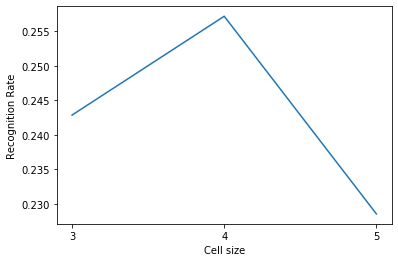

In [0]:
array_accuracies = []
array_pred = []
for size in [3,4,5]:
  #HoG features
  hog_data_train = extract_hog_features(all_patches_train, (size,size ))
  hog_data_test = extract_hog_features(all_patches_test, (size,size ))

  # BoW
  model_hog = bow_model(hog_data_train,nclusters)

  ## Creating the features
  train_feat = bow_vocab(model_hog,hog_data_train,nclusters)
  test_feat = bow_vocab(model_hog, hog_data_test,nclusters)

  ## Evaluation
  pred = nn(train_feat,train_labels,test_feat)
  acc = accuracy(pred,test_labels)
  print("The accuracy is " + str(acc*100) + "%")
  array_accuracies.append(acc)
  array_pred.append(pred)

plt.figure()
plt.plot([3,4,5],array_accuracies)

plt.ylabel("Recognition Rate")
plt.xlabel("Cell size")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

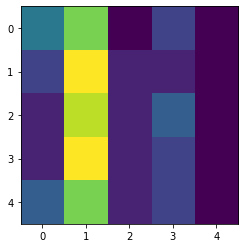

In [0]:
plt.imshow(conf_matrix(test_labels,array_pred[2]))

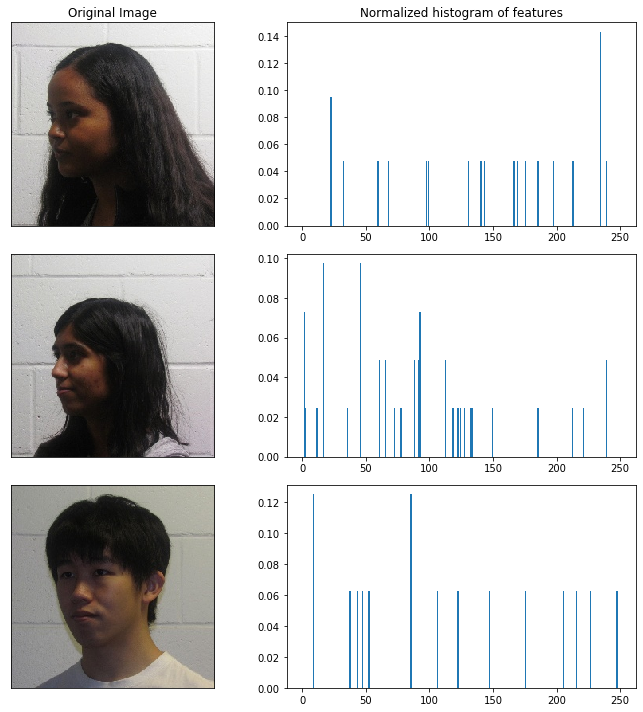

In [0]:
def bow_hist(gmm, descriptors,n_clusters):
  img_clustered_word = gmm.predict(descriptors)
  plt.hist(img_clustered_word,bins=n_clusters,range = (0,n_clusters),density=True)

plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.title("Original Image")
plt.imshow(train_x_preprocessed[0]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,2)
plt.title("Normalized histogram of features")
bow_hist(model_hog,hog_data_train[0],nclusters)

plt.subplot(3,2,3)
plt.imshow(train_x_preprocessed[16]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,4)
bow_hist(model_hog,hog_data_train[16],nclusters)

plt.subplot(3,2,5)
plt.imshow(train_x_preprocessed[31]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,6)
bow_hist(model_hog,hog_data_train[31],nclusters)

plt.tight_layout()
plt.show()

## Experiment 1.1.2

The accuracy is 15.714285714285714%
The accuracy is 25.71428571428571%
The accuracy is 18.571428571428573%


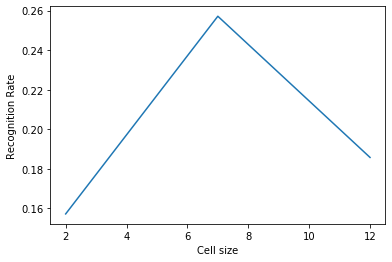

In [0]:
array_accuracies_LBP = []
array_pred_LBP = []

for radius in [2,7,12]:
  #LBP features
  LBP_data_train = extract_lbp_features(all_patches_train, radius)
  LBP_data_test = extract_lbp_features(all_patches_test, radius)

  # BoW
  model_LBP = bow_model(LBP_data_train,nclusters)

  ## Creating the features
  train_feat = bow_vocab(model_LBP,LBP_data_train,nclusters)
  test_feat = bow_vocab(model_LBP, LBP_data_test,nclusters)

  ## Evaluation
  pred = nn(train_feat,train_labels,test_feat)
  acc = accuracy(pred,test_labels)
  print("The accuracy is " + str(acc*100) + "%")
  array_accuracies_LBP.append(acc)
  array_pred_LBP.append(pred)

plt.figure()
plt.plot([2,7,12],array_accuracies_LBP)
plt.ylabel("Recognition Rate")
plt.xlabel("Radius")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

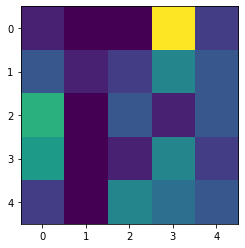

In [0]:
from sklearn.metrics import confusion_matrix as conf_matrix
plt.imshow(conf_matrix(test_labels,array_pred_LBP[2]))

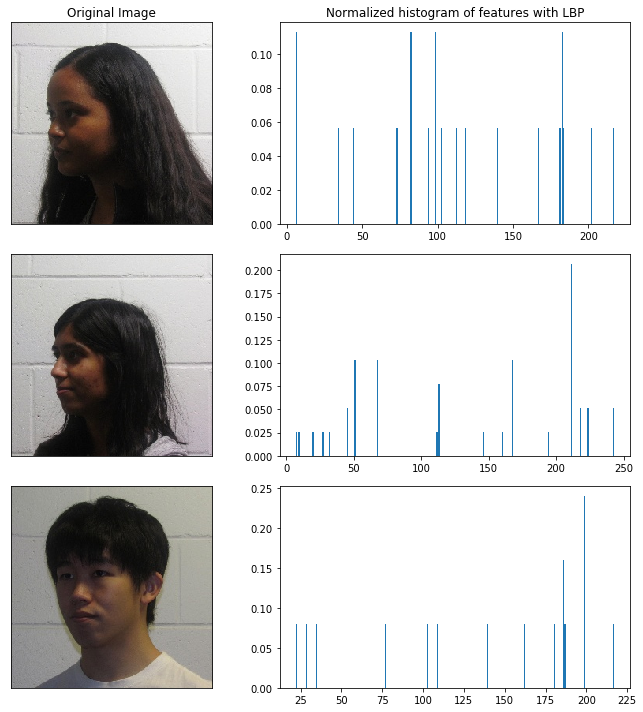

In [0]:
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.title("Original Image")
plt.imshow(train_x_preprocessed[0]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,2)
plt.title("Normalized histogram of features with LBP")
bow_hist(model_LBP,LBP_data_train[0],nclusters)

plt.subplot(3,2,3)
plt.imshow(train_x_preprocessed[16]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,4)
bow_hist(model_LBP,LBP_data_train[16],nclusters)

plt.subplot(3,2,5)
plt.imshow(train_x_preprocessed[31]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,6)
bow_hist(model_LBP,LBP_data_train[31],nclusters)

plt.tight_layout()
plt.show()

## Experiment 2

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (250). Possibly due to duplicate points in X.
  return_n_iter=True)


The accuracy is 14.285714285714285%
The accuracy is 25.71428571428571%
The accuracy is 27.142857142857142%


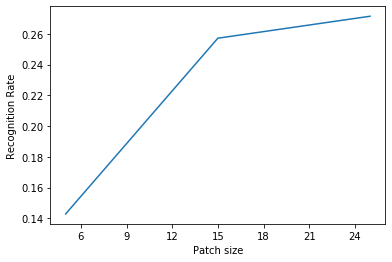

In [0]:
nclusters = 250

# Preprocessing
train_x_preprocessed = [preprocess(img,pad=0) for img in train_x]
test_x_preprocessed = [preprocess(img,pad=0) for img in test_x]
nclusters = 250

# Sift
keypoints_train, _ = all_sift(train_x_preprocessed)
keypoints_test, _ = all_sift(test_x_preprocessed)

# Remove points outside bounding box
bbox_train = pickle.load( open("bbox_train.pickle", 'rb'))
cropped_keypoints_train = crop_sift(keypoints_train, bbox_train)
bbox_test = pickle.load( open("bbox_test.pickle", 'rb'))
cropped_keypoints_test = crop_sift(keypoints_test, bbox_test)

array_accuracies_patches = []
array_pred_patches = []


best_radius = 7

for patch_size in [5,15,30]:

  # Patches
  all_patches_train = get_patches(train_x_preprocessed,cropped_keypoints_train,patch_size)
  all_patches_test = get_patches(test_x_preprocessed,cropped_keypoints_test,patch_size)

  #LBP features
  LBP_data_train = extract_lbp_features(all_patches_train, best_radius)
  LBP_data_test = extract_lbp_features(all_patches_test, best_radius)

  # BoW
  model_LBP = bow_model(LBP_data_train,nclusters)

  ## Creating the features
  train_feat = bow_vocab(model_LBP,LBP_data_train,nclusters)
  test_feat = bow_vocab(model_LBP, LBP_data_test,nclusters)

  ## Evaluation
  pred = nn(train_feat,train_labels,test_feat)
  acc = accuracy(pred,test_labels)
  print("The accuracy is " + str(acc*100) + "%")
  array_accuracies_patches.append(acc)
  array_pred_patches.append(pred)

plt.figure()
plt.plot([5,15,25],array_accuracies_patches)
plt.ylabel("Recognition Rate")
plt.xlabel("Patch size")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


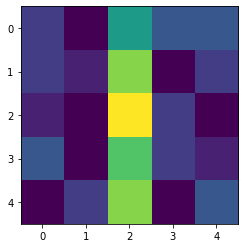

In [0]:
plt.imshow(conf_matrix(test_labels,array_pred_patches[2]))

In [0]:
## Displaying keypoints
sample_idx = [i+30 for i in range(10)]
sample_imgs = []
print(sample_idx)
for idx in sample_idx:
  img_disp = cv2.drawKeypoints(train_x_preprocessed[idx].copy(),cropped_keypoints_train[idx],train_x_preprocessed[idx].copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  sample_imgs.append(img_disp)

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

num_columns = 5
row = 10//num_columns + 1
col = num_columns
for i,img in enumerate(sample_imgs,1):
    ax = fig.add_subplot(row, col, i)
    ax.imshow(img.astype('uint8')), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

## Experiment 3

The accuracy is 23.52941176470588%


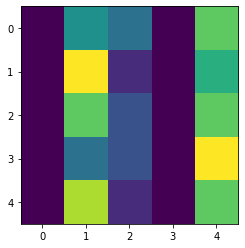

In [0]:
nclusters = 250

test_labels_copy = test_labels.copy()

# Sift
keypoints_train_harris = extract_harris(train_x_preprocessed)
keypoints_test_harris= extract_harris(test_x_preprocessed)

# Remove points outside bounding box
bbox_train = pickle.load( open("bbox_train.pickle", 'rb'))
cropped_keypoints_train_harris = crop_harris(keypoints_train_harris, bbox_train)
bbox_test = pickle.load( open("bbox_test.pickle", 'rb'))
cropped_keypoints_test_harris = crop_harris(keypoints_test_harris, bbox_test)

# Reject any empty array
cropped_keypoints_train_harris= [arr for arr in cropped_keypoints_train_harris if len(arr) != 0]
idx_bad_keypoints_test_harris= [i for i,arr in enumerate(cropped_keypoints_test_harris) if len(arr) == 0]
count = 0
for i in idx_bad_keypoints_test_harris:
  del cropped_keypoints_test_harris[i-count]
  count = count + 1

test_labels_copy =np.delete(test_labels_copy,idx_bad_keypoints_test_harris).reshape((-1,1))


# Parameters
best_size = 30
best_radius = 7

# Patches
all_patches_train = get_patches(train_x_preprocessed,
                                cropped_keypoints_train_harris,best_size)
all_patches_test = get_patches(test_x_preprocessed,
                               cropped_keypoints_test_harris,best_size)

#LBP features
LBP_data_train = extract_lbp_features(all_patches_train, best_radius)
LBP_data_test = extract_lbp_features(all_patches_test, best_radius)

# BoW
model_LBP = bow_model(LBP_data_train,nclusters)

## Creating the features
train_feat = bow_vocab(model_LBP,LBP_data_train,nclusters)
test_feat = bow_vocab(model_LBP, LBP_data_test,nclusters)

## Evaluation
pred = nn(train_feat,train_labels,test_feat)
acc = accuracy( np.array(pred),test_labels_copy )
conf = conf_matrix(test_labels_copy,pred)


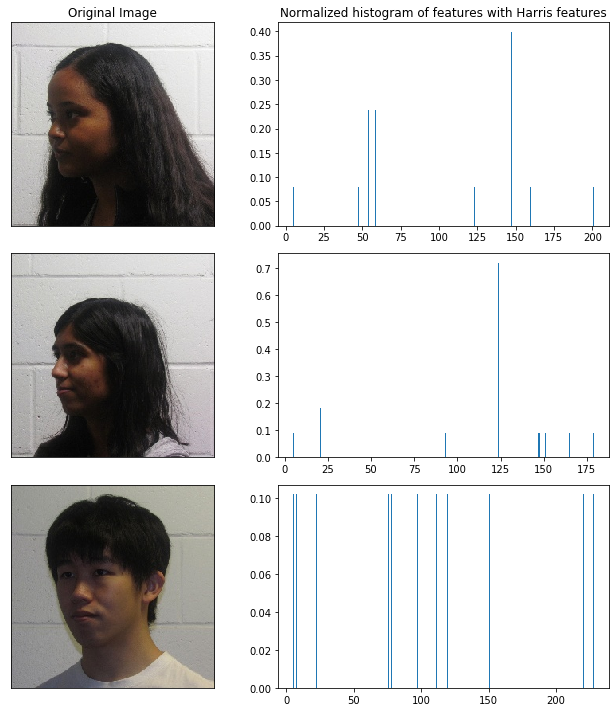

In [0]:
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.title("Original Image")
plt.imshow(train_x_preprocessed[0]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,2)
plt.title("Normalized histogram of features with Harris features")
bow_hist(model_LBP,LBP_data_train[0],nclusters)

plt.subplot(3,2,3)
plt.imshow(train_x_preprocessed[16]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,4)
bow_hist(model_LBP,LBP_data_train[16],nclusters)

plt.subplot(3,2,5)
plt.imshow(train_x_preprocessed[31]),plt.xticks([]),plt.yticks([])
plt.subplot(3,2,6)
bow_hist(model_LBP,LBP_data_train[31],nclusters)

plt.tight_layout()
plt.show()

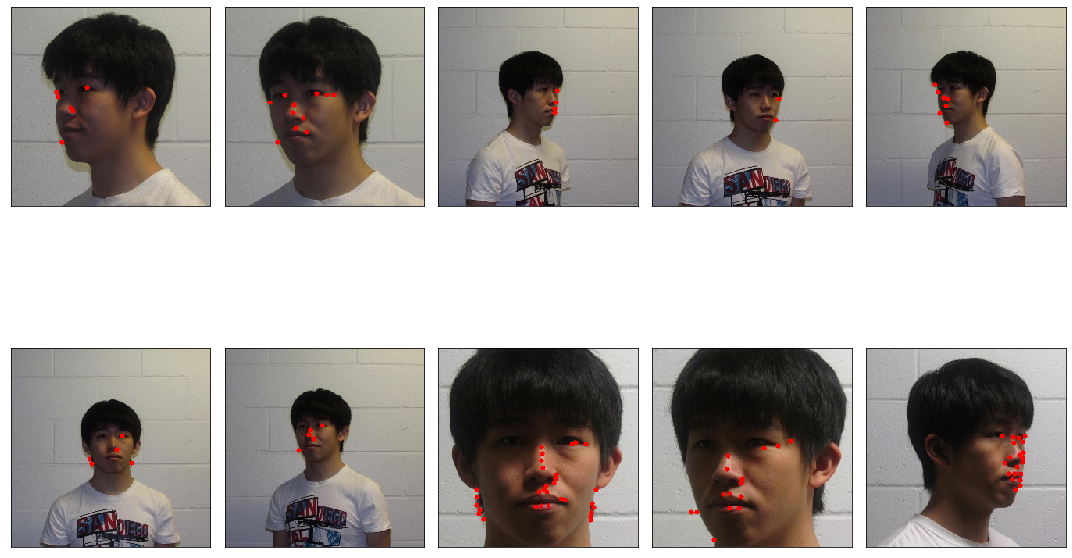

In [0]:
## Displaying keypoints
sample_idx = [i+30 for i in range(10)]
sample_imgs = []

for idx in sample_idx:
  img = train_x_preprocessed[idx].copy()
  for i in cropped_keypoints_train_harris[idx]:
    x = i[0]
    y = i[1]
    # print(x)
    cv2.circle(img,(x,y),3,255,-1)
  sample_imgs.append(img)

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

num_columns = 5
row = 10//num_columns + 1
col = num_columns
for i,img in enumerate(sample_imgs,1):
    ax = fig.add_subplot(row, col, i)
    ax.imshow(img.astype('uint8')), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()